In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import urllib.parse
from sklearn.feature_extraction.text import CountVectorizer
import string

2025-05-14 18:12:55.975514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747246376.461761      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747246376.599164      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/phishing-site-urls/phishing_site_urls.csv')
df.columns = ['url', 'label']
df['label'] = df['label'].map({'bad': 1, 'good': 0})

In [3]:
#URL Feature Engineering
def extract_url_features(url):
    """Extract multiple features from URLs for enhanced detection."""
    features = {}

    # Basic features
    url = url.lower()
    features['url_length'] = len(url)
    features['domain_length'] = len(urllib.parse.urlparse(url).netloc)

    # Count specific characters that are common in phishing URLs
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_underscores'] = url.count('_')
    features['num_slash'] = url.count('/')
    features['num_question_mark'] = url.count('?')
    features['num_equal'] = url.count('=')
    features['num_at'] = url.count('@')
    features['num_and'] = url.count('&')
    features['num_exclamation'] = url.count('!')
    features['num_space'] = url.count(' ')
    features['num_percent'] = url.count('%')
    features['num_tilde'] = url.count('~')
    features['num_comma'] = url.count(',')
    features['num_plus'] = url.count('+')
    features['num_asterisk'] = url.count('*')
    features['num_hashtag'] = url.count('#')
    features['num_dollar'] = url.count('$')

    # Check for HTTP/HTTPS
    features['has_https'] = int(url.startswith('https'))
    features['has_http'] = int(url.startswith('http'))

    # Check for suspicious words
    suspicious_words = ['login', 'verify', 'secure', 'account', 'update', 'bank', 'signin',
                         'confirm', 'password', 'webscr', 'ebayisapi', 'paypal', 'billing',
                          'submit', 'security', 'validate', 'authentication', 'support',
                           'alert', 'unlock', 'reset', 'identity', 'recovery', 'limited',
                            'service', 'access', 'authorize', 'credentials', 'payment', 'urgent',
                             'message', 'warning', 'win', 'free', 'bonus', 'click', 'verifyemail',
                              'suspend', 'locked', 'danger', 'checkout', 'invoice', 'order']
    for word in suspicious_words:
        features[f'contains_{word}'] = int(word in url)

    # Check for common TLDs
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc

    common_tlds = ['.com', '.org', '.net', '.edu', '.gov', '.co', '.io', '.info']
    for tld in common_tlds:
        features[f'has_{tld.replace(".", "")}'] = int(domain.endswith(tld))

    # Count digits in URL and domain
    features['num_digits_in_url'] = sum(c.isdigit() for c in url)
    features['num_digits_in_domain'] = sum(c.isdigit() for c in domain)

    # Entropy of domain
    if domain:
        char_counts = {}
        for char in domain:
            if char in char_counts:
                char_counts[char] += 1
            else:
                char_counts[char] = 1

        entropy = 0
        for count in char_counts.values():
            prob = count / len(domain)
            entropy -= prob * np.log2(prob)
        features['domain_entropy'] = entropy
    else:
        features['domain_entropy'] = 0

    return features


In [4]:
# Clean URLs
def clean_url(url):
    """Clean URL for text-based features while preserving important patterns."""
    # Convert to lowercase
    url = url.lower()

    # Remove common prefixes but preserve important parts
    url = re.sub(r"https?://", "httpx ", url)  # Replace with marker instead of removing
    url = re.sub(r"www\.", "www ", url)  # Replace with marker

    # Replace special characters with spaces to separate words
    for char in ['/', '?', '=', '&', '-', '_', '.', ':', ';', ',', '@', '!']:
        url = url.replace(char, ' ' + char + ' ')

    # Remove extra spaces
    url = re.sub(r'\s+', ' ', url).strip()

    return url

In [5]:
# Apply feature extraction
print("Extracting URL features...")
features_list = []
for url in tqdm(df['url']):
    features_list.append(extract_url_features(url))

# Convert features to DataFrame
features_df = pd.DataFrame(features_list)

# Normalize numerical features
for col in features_df.columns:
    if features_df[col].dtype != 'object':
        features_df[col] = (features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min() + 1e-8)

# Apply text cleaning
df['clean_url'] = df['url'].apply(clean_url)

Extracting URL features...


100%|██████████| 549346/549346 [00:17<00:00, 32051.68it/s]


In [6]:
MAX_SAMPLES_PER_CLASS = 40000
df_phishing = df[df['label'] == 1]
df_legitimate = df[df['label'] == 0]

In [7]:
# Downsample majority class
min_samples = min(MAX_SAMPLES_PER_CLASS, min(len(df_phishing), len(df_legitimate)))
df_phishing_balanced = df_phishing.sample(min_samples, random_state=42)
df_legitimate_balanced = df_legitimate.sample(min_samples, random_state=42)

In [8]:
# Combine the balanced classes
df_balanced = pd.concat([df_phishing_balanced, df_legitimate_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Join text features with engineered features
df_balanced = df_balanced.reset_index(drop=True)
features_df_balanced = features_df.loc[df_balanced.index].reset_index(drop=True)

In [10]:
# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_url'], df_balanced['label'],
    test_size=0.2, random_state=42, stratify=df_balanced['label'])

# Split the engineered features as well
X_train_features = features_df_balanced.iloc[X_train.index]
X_test_features = features_df_balanced.iloc[X_test.index]

# Convert engineered features to tensors
train_features_tensor = tf.convert_to_tensor(X_train_features.values, dtype=tf.float32)
test_features_tensor = tf.convert_to_tensor(X_test_features.values, dtype=tf.float32)

Splitting data...


I0000 00:00:1747246448.157438      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747246448.158181      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
# Initialize tokenizer with larger vocabulary
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", local_files_only=False)

# Tokenize data with increased max_length
max_length = 256  # Increased from 128
print("Tokenizing data...")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length, return_tensors="tf")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenizing data...


In [12]:
# Extract n-grams for character-level features
print("Extracting character n-grams...")
char_vectorizer = CountVectorizer(
    analyzer='char',
    ngram_range=(3, 5),  # Character n-grams from 3 to 5
    max_features=300  # Limit to top features
)
# Fit and transform on clean URLs
X_train_ngrams = char_vectorizer.fit_transform(X_train).toarray()
X_test_ngrams = char_vectorizer.transform(X_test).toarray()

# Convert to tensors
train_ngrams_tensor = tf.convert_to_tensor(X_train_ngrams, dtype=tf.float32)
test_ngrams_tensor = tf.convert_to_tensor(X_test_ngrams, dtype=tf.float32)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

Extracting character n-grams...


In [13]:
# Create TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "url_features": train_features_tensor,
        "char_ngrams": train_ngrams_tensor
    },
    train_labels
)).shuffle(buffer_size=10000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        "url_features": test_features_tensor,
        "char_ngrams": test_ngrams_tensor
    },
    test_labels
)).batch(32)

In [14]:
# Define the improved model with multiple inputs and advanced architecture
class ImprovedRoBERTaModel(tf.keras.Model):
    def __init__(self, dropout_rate=0.3, num_classes=2):
        super(ImprovedRoBERTaModel, self).__init__()

        # Load RoBERTa with custom configuration
        config = RobertaConfig.from_pretrained("roberta-base")
        config.hidden_dropout_prob = dropout_rate
        config.attention_probs_dropout_prob = dropout_rate
        self.roberta = TFRobertaModel.from_pretrained("roberta-base", config=config)

        # Fine-tune the entire model
        self.roberta.trainable = True

        # Multi-head attention layer
        self.attention_heads = 8
        self.attention_size = 64
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=self.attention_heads,
            key_dim=self.attention_size
        )

        # Additional layers for URL features
        self.url_features_dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.url_features_bn1 = tf.keras.layers.BatchNormalization()
        self.url_features_dropout1 = tf.keras.layers.Dropout(dropout_rate)

        # Layers for character n-grams
        self.ngram_dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.ngram_bn1 = tf.keras.layers.BatchNormalization()
        self.ngram_dropout1 = tf.keras.layers.Dropout(dropout_rate)

        # Layers for text embeddings
        self.text_dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.text_bn1 = tf.keras.layers.BatchNormalization()
        self.text_dropout1 = tf.keras.layers.Dropout(dropout_rate)

        # Feature fusion layers
        self.fusion_dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.fusion_bn1 = tf.keras.layers.BatchNormalization()
        self.fusion_dropout1 = tf.keras.layers.Dropout(dropout_rate)

        # Second fusion layer
        self.fusion_dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.fusion_bn2 = tf.keras.layers.BatchNormalization()
        self.fusion_dropout2 = tf.keras.layers.Dropout(dropout_rate)

        # Classification layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        # Extract different input types
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        url_features = inputs["url_features"]
        char_ngrams = inputs["char_ngrams"]

        # Process URL features
        url_features_output = self.url_features_dense1(url_features)
        url_features_output = self.url_features_bn1(url_features_output, training=training)
        url_features_output = self.url_features_dropout1(url_features_output, training=training)

        # Process character n-grams
        ngram_output = self.ngram_dense1(char_ngrams)
        ngram_output = self.ngram_bn1(ngram_output, training=training)
        ngram_output = self.ngram_dropout1(ngram_output, training=training)

        # Process text with RoBERTa
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]

        # Apply multi-head attention
        attention_output = self.multi_head_attention(
            query=roberta_output,
            value=roberta_output,
            attention_mask=tf.cast(tf.expand_dims(attention_mask, axis=1), tf.bool),
            training=training
        )

        # Global average pooling
        text_vector = tf.reduce_mean(attention_output, axis=1)

        # Process text embeddings
        text_output = self.text_dense1(text_vector)
        text_output = self.text_bn1(text_output, training=training)
        text_output = self.text_dropout1(text_output, training=training)

        # Concatenate all features
        combined_features = tf.concat([text_output, url_features_output, ngram_output], axis=1)

        # Fusion layers
        fusion_output = self.fusion_dense1(combined_features)
        fusion_output = self.fusion_bn1(fusion_output, training=training)
        fusion_output = self.fusion_dropout1(fusion_output, training=training)

        fusion_output = self.fusion_dense2(fusion_output)
        fusion_output = self.fusion_bn2(fusion_output, training=training)
        fusion_output = self.fusion_dropout2(fusion_output, training=training)

        # Classification
        output = self.classifier(fusion_output)

        return output

In [15]:
# F1 score metric
def f1_score(y_true, y_pred):
    # Calculate precision and recall
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_pred_onehot = tf.one_hot(y_pred_classes, depth=2)

    true_positives = tf.reduce_sum(y_pred_onehot[:, 1] * tf.cast(y_true, tf.float32))
    pred_positives = tf.reduce_sum(y_pred_onehot[:, 1])
    actual_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

    precision = true_positives / (pred_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

model = ImprovedRoBERTaModel(dropout_rate=0.2)

# Setup learning rate schedule with warmup
initial_learning_rate = 2e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=1000,
    end_learning_rate=1e-6,
    power=1.0
)

# Compile model with weighted loss to further address any class imbalance
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", f1_score]
)

# Setup callbacks for better training
callbacks = [
    TqdmCallback(verbose=1),
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        mode='min'
    ),
    ModelCheckpoint(
        filepath='best_phishing_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [17]:
# Initialize model's weights
sample = next(iter(train_dataset))[0]
_ = model(sample, training=False)

# Train model with longer epochs
print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=10,  # Increased epochs
    callbacks=callbacks,
    validation_data=test_dataset
)

# Evaluate model
print("\nEvaluating model...")
preds_raw = []
true_labels = []

for batch in test_dataset:
    features, labels = batch
    batch_preds = model(features, training=False)
    preds_raw.append(batch_preds.numpy())
    true_labels.append(labels.numpy())

preds = np.vstack(preds_raw)
test_labels_all = np.concatenate(true_labels)

y_pred = np.argmax(preds, axis=1)
y_probs = preds[:, 1]

print("\nClassification Report:")
print(classification_report(test_labels_all, y_pred))

# Validation accuracy
val_accuracy = np.mean(y_pred == test_labels_all)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Starting model training...
Epoch 1/10


I0000 00:00:1747246522.828674     100 service.cc:148] XLA service 0x7dbeec01dfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747246522.830491     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747246522.830513     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1747246523.747903     100 assert_op.cc:38] Ignoring Assert operator improved_ro_ber_ta_model_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert
I0000 00:00:1747246525.847220     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747246534.315268     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7912 - f1_score: 0.7931 - loss: 0.5069

W0000 00:00:1747247420.162660     100 assert_op.cc:38] Ignoring Assert operator improved_ro_ber_ta_model_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1137s 551ms/step - accuracy: 0.7913 - f1_score: 0.7931 - loss: 0.5068 - val_accuracy: 0.8982 - val_f1_score: 0.8988 - val_loss: 0.2496 - learning_rate: 1.0000e-06
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1096s 548ms/step - accuracy: 0.8762 - f1_score: 0.8749 - loss: 0.3106 - val_accuracy: 0.8994 - val_f1_score: 0.9007 - val_loss: 0.2485 - learning_rate: 1.0000e-06
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1096s 548ms/step - accuracy: 0.8809 - f1_score: 0.8797 - loss: 0.3009 - val_accuracy: 0.9059 - val_f1_score: 0.9066 - val_loss: 0.2339 - learning_rate: 1.0000e-06
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1095s 548ms/step - accuracy: 0.8880 - f1_score: 0.8870 - loss: 0.2843 - val_accuracy: 0.9102 - val_f1_score: 0.9106 - val_loss: 0.2231 - learning_rate: 1.0000e-06
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1095s 548ms/step - accuracy: 0.8877 - f1_score: 0.8866 - loss: 0.2850 - val_accuracy: 0.9111 - val_f1_score: 0.9117 - val_loss: 0.2209 - learning_rat

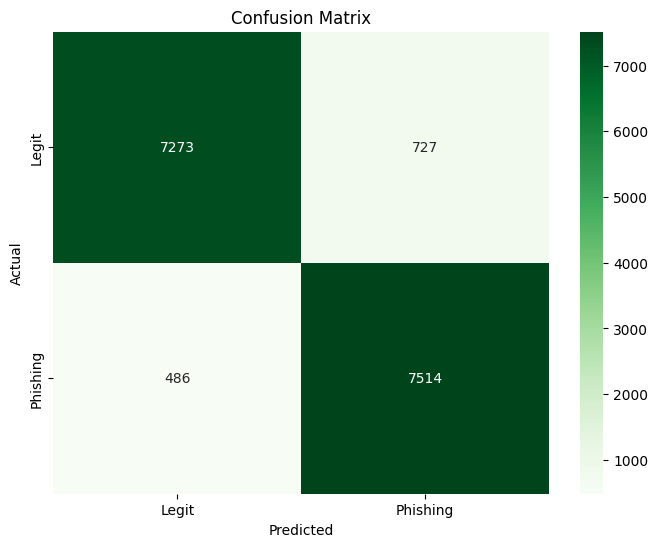

In [18]:
# Confusion matrix
cm = confusion_matrix(test_labels_all, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Legit', 'Phishing'],
            yticklabels=['Legit', 'Phishing'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

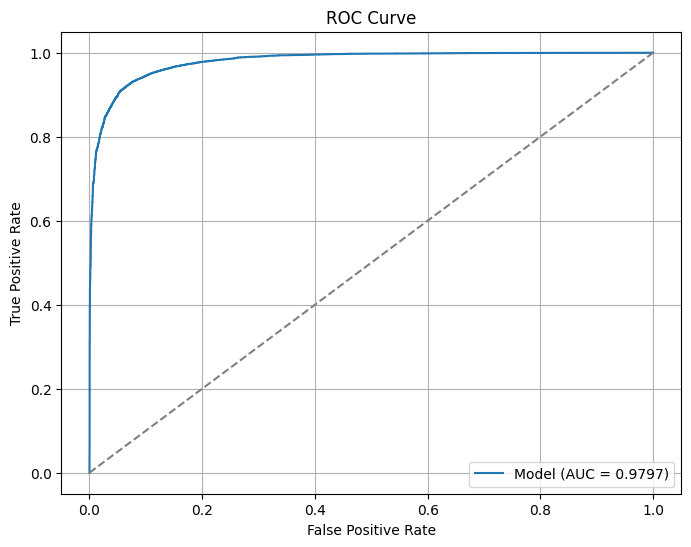

In [19]:
# ROC curve
fpr, tpr, _ = roc_curve(test_labels_all, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


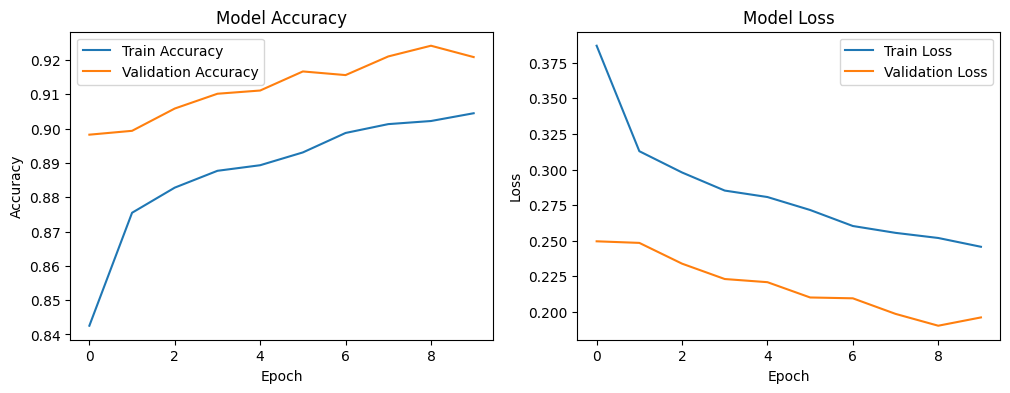

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [21]:
# Save the model
model.save_weights("phishing.weights.h5")
model.save("phishing.h5")
model.save("phishing.keras")
print("\nModel saved successfully!")


Model saved successfully!
